<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

fatal: destination path 'Sarcasm_Detection' already exists and is not an empty directory.


#Expirimentation with CNN Architecture for Sarcasm Detection

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train_bal_2.csv')

In [55]:
train_bal

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,exclamation_count,questionmark_count,period_count,space_count,slash_count,elips_count,capital_letters_count,word_count,total_punctuation
0,522142,0,"I personally wasn't a huge Garrosh fan, I've a...",cromemako83,AskReddit,2,2,0,2015-07-01,2015-07-11 01:55:53,Fuck Vol'jin. Garrosh Hellscream did nothing w...,0,0,1,0,0,0,5,14,4
1,907864,1,you forgot the,_SharkWeek_,AskReddit,1,1,0,2013-03-01,2013-03-14 03:03:46,That's a lie fed to you by the LIEberal media....,0,0,0,0,0,0,0,3,0
2,604170,1,"Nah man, she's clearly an ad carry",jdswift13,leagueoflegends,1,1,0,2015-10-01,2015-10-21 23:22:17,she isnt already?,0,0,0,0,0,0,1,7,2
3,110635,1,This sub in a nutshell.,trickz-M-,GlobalOffensive,1,-1,-1,2016-12-01,2016-12-05 03:50:18,Cloud 9 Qualify! (ONLY C9 FANS ALLOWED(,0,0,1,0,0,0,1,5,1
4,997758,0,Yes... I do.,guriboysf,videos,4,4,0,2010-01-01,2010-01-17 21:32:40,"""so, i hear you have a fat cock.""",0,0,4,0,0,0,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808613,368312,1,"Yeah, all asians are smart, right?",est1roth,europe,2,2,0,2016-04-01,2016-04-17 00:05:51,"Well if an asian woman says it, it must be true.",0,1,0,0,0,0,1,6,3
808614,541588,1,Nah I was serious,SrrBrrGrr,funny,-5,-5,0,2015-08-01,2015-08-11 23:15:11,I don't think people understand you were jokin...,0,0,0,0,0,0,2,4,0
808615,833824,0,you are assuming way too much there is no liab...,cqm,blog,1,1,0,2014-09-01,2014-09-30 21:44:06,They're not saying it is easy. In fact they we...,0,0,0,0,0,0,0,41,6
808616,55102,1,But Planned Parenthood is the devil and must b...,DrScientist812,worldnews,3,3,0,2016-09-01,2016-09-06 12:40:25,Fall in ovarian cancer deaths worldwide linked...,1,0,0,0,0,0,3,13,1


In [56]:
import re, string, time, nltk
import numpy as np
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwordprovider
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808618 entries, 0 to 808617
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Unnamed: 0             808618 non-null  int64 
 1   label                  808618 non-null  int64 
 2   comment                808618 non-null  object
 3   author                 808618 non-null  object
 4   subreddit              808618 non-null  object
 5   score                  808618 non-null  int64 
 6   ups                    808618 non-null  int64 
 7   downs                  808618 non-null  int64 
 8   date                   808618 non-null  object
 9   created_utc            808618 non-null  object
 10  parent_comment         808618 non-null  object
 11  exclamation_count      808618 non-null  int64 
 12  questionmark_count     808618 non-null  int64 
 13  period_count           808618 non-null  int64 
 14  space_count            808618 non-null  int64 
 15  

In [58]:
y = train_bal['label']
X = train_bal.drop(columns=['label'])

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#Preparing train data

In [60]:
X_text = X_train[['comment', 'parent_comment']]
X_numeric = X_train[['word_count', 'capital_letters_count', 'total_punctuation']]

In [61]:
X_numeric.shape[0]

646894

In [62]:
X_text.shape[0]

646894

In [63]:
max_words = 10000  # Maximum number of words to keep based on word frequency
max_seq_length = 100  # Maximum length of sequences

In [64]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(X_text['comment'] + ' ' + X_text['parent_comment'])

***Possibly tokenize differenlty for comment and parent comment****

In [65]:
X_text_comment_seq = tokenizer.texts_to_sequences(X_text['comment'])
X_text_parent_comment_seq = tokenizer.texts_to_sequences(X_text['parent_comment'])

In [66]:
X_text_comment_pad = pad_sequences(X_text_comment_seq, maxlen=max_seq_length)
X_text_parent_comment_pad = pad_sequences(X_text_parent_comment_seq, maxlen=max_seq_length)

In [67]:
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

#Word2vec model trained on our text data

In [68]:
import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec
word2vec = gensim.models.Word2Vec.load('/content/drive/MyDrive/Sarcasm_Data/word2vec.model')

In [69]:
similar_words = word2vec.wv.most_similar('ok')
similar_words

[('okay', 0.9446449279785156),
 ('OK', 0.9253052473068237),
 ('alright', 0.7982171773910522),
 ('fine', 0.6672182083129883),
 ('perfectly_fine', 0.642020046710968),
 ('cool', 0.5878971815109253),
 ('justified', 0.5626591444015503),
 ('wrong', 0.5318138599395752),
 ('understandable', 0.5288909077644348),
 ('unacceptable', 0.4947114884853363)]

In [70]:
from gensim.models import Word2Vec

word_index = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key, start=1)}


In [71]:
import numpy as np
from keras.layers import Embedding

# Assume word2vec is your pre-trained Word2Vec model
# Assume word_index is a dictionary mapping from word to integer index
# Assume max_words is the size of your vocabulary, and word2vec.vector_size is the size of each word vector

embedding_dim = word2vec.vector_size
max_words = len(word_index) + 1  # Adjust based on whether you start indexing from 0 or 1

# Initialize the embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))

# # Populate the embedding matrix
# for word, i in word_index.items():
#     if i < max_words:
#         if word in word2vec.wv:
#             # Words not found in the embedding index will be all zeros
#             embedding_matrix[i] = word2vec.wv[word]



In [72]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))

# Populate the embedding matrix using the tokenizer's word_index
for word, i in tokenizer.word_index.items():
    if i < max_words:  # Ensure you don't exceed the max_words limit
        if word in word2vec.wv:
            embedding_matrix[i] = word2vec.wv[word]


In [73]:
embedding_dim

150

#Preparing Test Data

In [74]:
X_text_test = X_test[['comment', 'parent_comment']]
X_numeric_test = X_test[['word_count', 'capital_letters_count', 'total_punctuation']]

In [75]:
X_text_comment_seq_test = tokenizer.texts_to_sequences(X_text_test['comment'])
X_text_parent_comment_seq_test = tokenizer.texts_to_sequences(X_text_test['parent_comment'])

In [76]:
X_text_comment_pad_test = pad_sequences(X_text_comment_seq_test, maxlen=max_seq_length)
X_text_parent_comment_pad_test = pad_sequences(X_text_parent_comment_seq_test, maxlen=max_seq_length)

In [77]:
scaler = StandardScaler()
X_numeric_scaled_test = scaler.fit_transform(X_numeric_test)

In [78]:
pip install keras-tuner


##CNN Text Covariates

In [79]:


# from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout, Bidirectional, LSTM
# from keras.models import Model
# from keras import optimizers
# from kerastuner import HyperModel

# def build_model1(hp):
#     comment_input = Input(shape=(max_seq_length,), name='comment_input')
#     parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')

#     embedding_layer = Embedding(input_dim=max_words,
#                                 output_dim=150,
#                                 weights=[embedding_matrix],
#                                 input_length=max_seq_length,
#                                 trainable=True)

#     comment_embedding = embedding_layer(comment_input)
#     parent_comment_embedding = embedding_layer(parent_comment_input)

#     concatenated_embeddings = concatenate([comment_embedding, parent_comment_embedding], axis=1)

#     conv1 = Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
#                    kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
#                    padding='same',
#                    activation='relu')(concatenated_embeddings)
#     conv1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = Conv1D(filters=hp.Int('conv2_filters', min_value=32, max_value=64, step=32),
#                    kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
#                    padding='same',
#                    activation='relu')(conv1)
#     conv2 = MaxPooling1D(pool_size=2)(conv2)


#     flattened = Flatten()(conv2)
#     flattened = Dropout(0.5)(flattened)

#     dense = Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu')(flattened)
#     output = Dense(1, activation='sigmoid')(dense)

#     model = Model(inputs=[comment_input, parent_comment_input], outputs=output)

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model

In [80]:
# from kerastuner.tuners import RandomSearch

# tuner = RandomSearch(
#     build_model1,
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='hparam_tuning'
# )

# tuner.search_space_summary()

# tuner.search(x=[X_text_comment_pad, X_text_parent_comment_pad],
#              y=y_train,
#              epochs=4,
#              batch_size=128,
#              validation_split=0.10)



# best_model = tuner.get_best_models(num_models=1)[0]

In [81]:
# from kerastuner.tuners import RandomSearch
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("Best hyperparameters:")
# for hp in best_hp.values:
#     print(f"{hp}: {best_hp.get(hp)}")

In [82]:
# best_model.save('/content/drive/MyDrive/Sarcasm_Data/best_model.h5')

In [83]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/drive/MyDrive/Sarcasm_Data/best_model.h5')

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Model

predictions = best_model.predict({'comment_input': X_text_comment_pad_test,
                             'parent_comment_input': X_text_parent_comment_pad_test})

prediction_result = (predictions > 0.5).astype('int32')

accuracy = accuracy_score(y_test, prediction_result)
print('Accuracy: %f' % accuracy)


precision = precision_score(y_test, prediction_result)
print('Precision: %f' % precision)


recall = recall_score(y_test, prediction_result)
print('Recall: %f' % recall)


f1 = f1_score(y_test, prediction_result)
print('F1 score: %f' % f1)


predictions = predictions.flatten()
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

5054/5054 [==============================] - 143s 28ms/step
Accuracy: 0.725471
Precision: 0.740457
Recall: 0.696643
F1 score: 0.717882
ROC AUC: 0.801096


#CNN text and non-text covariates

In [85]:
from keras.backend import clear_session
clear_session()

In [86]:
# from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
# from keras.models import Model
# from keras import optimizers

# comment_input = Input(shape=(max_seq_length,), name='comment_input')
# parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')
# numeric_input = Input(shape=(X_numeric_scaled.shape[1],), name='numeric_input')

# embedding_layer = Embedding(input_dim=max_words,
#                             output_dim=150,
#                             weights=[embedding_matrix],
#                             input_length=max_seq_length,
#                             trainable=True)

# comment_embedding = embedding_layer(comment_input)
# parent_comment_embedding = embedding_layer(parent_comment_input)

# concatenated_embeddings = concatenate([comment_embedding, parent_comment_embedding], axis=1)

# conv1 = Conv1D(filters=64,
#                kernel_size=5,
#                padding='same',
#                activation='relu')(concatenated_embeddings)
# conv1 = MaxPooling1D(pool_size=2)(conv1)

# conv2 = Conv1D(filters=64,
#                kernel_size=3,
#                padding='same',
#                activation='relu')(conv1)
# conv2 = MaxPooling1D(pool_size=2)(conv2)


# flattened = Flatten()(conv2)
# flattened = Dropout(0.5)(flattened)


# numeric_dense = Dense(64, activation='relu')(numeric_input)
# numeric_dense = Dropout(0.5)(numeric_dense)
# numeric_dense = Dense(32, activation='relu')(numeric_dense)


# concatenated_final = concatenate([flattened, numeric_dense], axis=-1)

# dense1 = Dense(64, activation='relu')(concatenated_final)
# dense1 = Dropout(0.5)(dense1)
# output = Dense(1, activation='sigmoid')(dense1)

# best_CNN_textandnontext= Model(inputs=[comment_input, parent_comment_input, numeric_input], outputs=output)
# best_CNN_textandnontext.compile(optimizer=optimizers.Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])






In [87]:
# best_CNN_textandnontext.fit({'comment_input': X_text_comment_pad, 'parent_comment_input': X_text_parent_comment_pad, 'numeric_input': X_numeric_scaled}, y_train, epochs=5, batch_size=128, validation_split=0.1)

In [88]:
# best_CNN_textandnontext.save('/content/drive/MyDrive/Sarcasm_Data/best_CNN_textandnontext.h5')

In [89]:
from tensorflow.keras.models import load_model
best_CNN_textandnontext = load_model('/content/drive/MyDrive/Sarcasm_Data/best_CNN_textandnontext.h5')

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Model

predictions = best_CNN_textandnontext.predict({'comment_input': X_text_comment_pad_test,
                             'parent_comment_input': X_text_parent_comment_pad_test,
                                               'numeric_input': X_numeric_scaled_test})

prediction_result = (predictions > 0.5).astype('int32')

accuracy = accuracy_score(y_test, prediction_result)
print('Accuracy: %f' % accuracy)


precision = precision_score(y_test, prediction_result)
print('Precision: %f' % precision)


recall = recall_score(y_test, prediction_result)
print('Recall: %f' % recall)


f1 = f1_score(y_test, prediction_result)
print('F1 score: %f' % f1)


predictions = predictions.flatten()
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

5054/5054 [==============================] - 146s 29ms/step
Accuracy: 0.691926
Precision: 0.657533
Recall: 0.804640
F1 score: 0.723686
ROC AUC: 0.787413


#Bi-LSTM Text Covariates

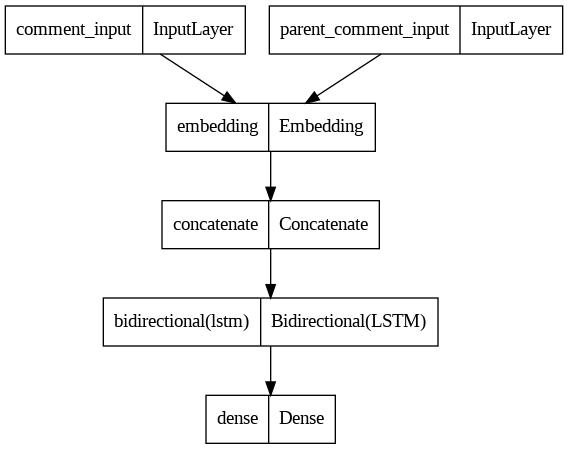

In [91]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, concatenate
from keras.callbacks import History


comment_input = Input(shape=(max_seq_length,), name='comment_input')
parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')

embedding_layer = Embedding(input_dim=max_words,
                            output_dim=150,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=True)

comment_embedding = embedding_layer(comment_input)
parent_comment_embedding = embedding_layer(parent_comment_input)


concatenated_embeddings = concatenate([comment_embedding, parent_comment_embedding], axis=1)


bi_lstm = Bidirectional(LSTM(64))(concatenated_embeddings)


output = Dense(1, activation='sigmoid')(bi_lstm)

bilstm_text = Model(inputs=[comment_input, parent_comment_input], outputs=output)
bilstm_text.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


plot_model(bilstm_text)


In [92]:
# bilstm_text.fit({'comment_input': X_text_comment_pad,
#            'parent_comment_input': X_text_parent_comment_pad},
#           y_train,
#           epochs=5,
#           batch_size=128,
#           validation_split=0.1)


#CNN with BiLSTM Text and Non-Text Covariates

In [93]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)


In [94]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras import optimizers

comment_input = Input(shape=(max_seq_length,), name='comment_input')
parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')
numeric_input = Input(shape=(X_numeric_scaled.shape[1],), name='numeric_input')

embedding_layer = Embedding(input_dim=max_words,
                            output_dim=150,
                            weights=[embedding_matrix],
                            input_length=max_seq_length,
                            trainable=True)

comment_embedding = embedding_layer(comment_input)
parent_comment_embedding = embedding_layer(parent_comment_input)

concatenated_embeddings = concatenate([comment_embedding, parent_comment_embedding], axis=1)

conv1 = Conv1D(filters=64,
               kernel_size=5,
               padding='same',
               activation='relu')(concatenated_embeddings)
conv1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(filters=64,
               kernel_size=3,
               padding='same',
               activation='relu')(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)


bi_lstm = Bidirectional(LSTM(64))(conv2)


bi_lstm = Dropout(0.5)(bi_lstm)


numeric_dense = Dense(64, activation='relu')(numeric_input)
numeric_dense = Dropout(0.5)(numeric_dense)
numeric_dense = Dense(32, activation='relu')(numeric_dense)


concatenated_final = concatenate([bi_lstm, numeric_dense], axis=-1)

dense1 = Dense(64, activation='relu')(concatenated_final)
dense1 = Dropout(0.5)(dense1)
output = Dense(1, activation='sigmoid')(dense1)

best_CNNBiLSTM_textandnontext = Model(inputs=[comment_input, parent_comment_input, numeric_input], outputs=output)
best_CNNBiLSTM_textandnontext.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [95]:
# best_CNNBiLSTM_textandnontext.fit({'comment_input': X_text_comment_pad, 'parent_comment_input': X_text_parent_comment_pad, 'numeric_input': X_numeric_scaled}, y_train, epochs=5, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

In [96]:
# best_CNNBiLSTM_textandnontext.save('/content/drive/MyDrive/Sarcasm_Data/best_CNNBiLSTM_textandnontext.h5')

In [97]:
from tensorflow.keras.models import load_model
best_CNNBiLSTM_textandnontext = load_model('/content/drive/MyDrive/Sarcasm_Data/best_CNNBiLSTM_textandnontext.h5')

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Model

predictions = best_CNNBiLSTM_textandnontext.predict({'comment_input': X_text_comment_pad_test,
                             'parent_comment_input': X_text_parent_comment_pad_test,
                                               'numeric_input': X_numeric_scaled_test})

prediction_result = (predictions > 0.5).astype('int32')

accuracy = accuracy_score(y_test, prediction_result)
print('Accuracy: %f' % accuracy)


precision = precision_score(y_test, prediction_result)
print('Precision: %f' % precision)


recall = recall_score(y_test, prediction_result)
print('Recall: %f' % recall)


f1 = f1_score(y_test, prediction_result)
print('F1 score: %f' % f1)


predictions = predictions.flatten()
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

5054/5054 [==============================] - 188s 37ms/step
Accuracy: 0.683962
Precision: 0.655335
Recall: 0.779789
F1 score: 0.712166
ROC AUC: 0.773351


#CNN with BiLSTM Text


In [99]:
# from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout, Bidirectional, LSTM
# from keras.models import Model
# from keras import optimizers
# from keras_tuner import HyperModel

# def build_model2(hp):
#     comment_input = Input(shape=(max_seq_length,), name='comment_input')
#     parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')

#     embedding_layer = Embedding(input_dim=max_words,
#                                 output_dim=150,
#                                 weights=[embedding_matrix],
#                                 input_length=max_seq_length,
#                                 trainable=True)

#     comment_embedding = embedding_layer(comment_input)
#     parent_comment_embedding = embedding_layer(parent_comment_input)

#     concatenated_embeddings = concatenate([comment_embedding, parent_comment_embedding], axis=1)

#     conv1 = Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
#                    kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
#                    padding='same',
#                    activation='relu')(concatenated_embeddings)
#     conv1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = Conv1D(filters=hp.Int('conv2_filters', min_value=32, max_value=64, step=32),
#                    kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
#                    padding='same',
#                    activation='relu')(conv1)
#     conv2 = MaxPooling1D(pool_size=2)(conv2)

#     bi_lstm = Bidirectional(LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64)))(conv2)

#     # Because we've added a Bi-LSTM layer, we no longer need to flatten the conv2 output
#     bi_lstm = Dropout(0.5)(bi_lstm)

#     dense = Dense(hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu')(bi_lstm)
#     output = Dense(1, activation='sigmoid')(dense)

#     model = Model(inputs=[comment_input, parent_comment_input], outputs=output)

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model


In [101]:
# from kerastuner.tuners import RandomSearch

# tuner = RandomSearch(
#     build_model2,
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='hparam_tuning'
# )

# tuner.search_space_summary()

# tuner.search(x=[X_text_comment_pad, X_text_parent_comment_pad],
#              y=y_train,
#              epochs=4,
#              batch_size=128,
#              validation_split=0.10)



# bestCNNBiLSTM = tuner.get_best_models(num_models=1)[0]

In [ ]:
# bestCNNBiLSTM.save('/content/drive/MyDrive/Sarcasm_Data/bestCNNBiLSTM.h5')

In [ ]:
from tensorflow.keras.models import load_model
bestCNNBiLSTM = load_model('/content/drive/MyDrive/Sarcasm_Data/bestCNNBiLSTM.h5')

Best Accuracy so Far

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Model

predictions = bestCNNBiLSTM .predict({'comment_input': X_text_comment_pad_test,
                             'parent_comment_input': X_text_parent_comment_pad_test})

prediction_result = (predictions > 0.5).astype('int32')

accuracy = accuracy_score(y_test, prediction_result)
print('Accuracy: %f' % accuracy)


precision = precision_score(y_test, prediction_result)
print('Precision: %f' % precision)


recall = recall_score(y_test, prediction_result)
print('Recall: %f' % recall)


f1 = f1_score(y_test, prediction_result)
print('F1 score: %f' % f1)


predictions = predictions.flatten()
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

#CNN with BiLSTM Text and Non-Text - Attention Mechanism added for numeric data

In [102]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout, Bidirectional, LSTM, Permute, Multiply, Lambda, RepeatVector
from keras.models import Model
from keras import optimizers, backend as K
from keras_tuner import HyperModel

def build_model3(hp):
    comment_input = Input(shape=(max_seq_length,), name='comment_input')
    parent_comment_input = Input(shape=(max_seq_length,), name='parent_comment_input')
    numeric_input = Input(shape=(X_numeric_scaled.shape[1],), name='numeric_input')

    embedding_layer = Embedding(input_dim=max_words,
                                output_dim=150,
                                weights=[embedding_matrix],
                                input_length=max_seq_length,
                                trainable=True)

    comment_embedding = embedding_layer(comment_input)
    parent_comment_embedding = embedding_layer(parent_comment_input)

    concatenated_embeddings = concatenate([comment_embedding, parent_comment_embedding], axis=1)

    conv1 = Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                   kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
                   padding='same',
                   activation='relu')(concatenated_embeddings)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv1 = Dropout(hp.Float('dropout_conv1', min_value=0.0, max_value=0.5, step=0.1))(conv1)

    conv2 = Conv1D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                   kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
                   padding='same',
                   activation='relu')(conv1)
    conv2 = MaxPooling1D(pool_size=2)(conv2)
    conv2 = Dropout(hp.Float('dropout_conv2', min_value=0.0, max_value=0.5, step=0.1))(conv2)

    bi_lstm = Bidirectional(LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64)))(conv2)
    bi_lstm = Dropout(hp.Float('dropout_lstm', min_value=0.0, max_value=0.5, step=0.1))(bi_lstm)

    # Attention mechanism for numeric input
    attention_probs = Dense(1, activation='softmax', name='attention_vec')(numeric_input)
    attention_mul = Multiply()([bi_lstm, attention_probs])

    # Combine the attention output with the original bi-LSTM output
    combined_features = concatenate([attention_mul, bi_lstm])

    dense = Dense(hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu')(combined_features)
    dense = Dropout(hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1))(dense)

    output = Dense(1, activation='sigmoid')(dense)

    bestCNNBiLSTMAll = Model(inputs=[comment_input, parent_comment_input, numeric_input], outputs=output)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    bestCNNBiLSTMAll.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return bestCNNBiLSTMAll


In [1]:
from kerastuner.tuners import RandomSearch

tuner2 = RandomSearch(
    build_model3,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

tuner2.search_space_summary()

tuner2.search(x=[X_text_comment_pad, X_text_parent_comment_pad, X_numeric_scaled],
             y=y_train,
             epochs=4,
             batch_size=128,
             validation_split=0.10)



bestCNNBiLSTMAll = tuner2.get_best_models(num_models=1)[0]

ModuleNotFoundError: No module named 'kerastuner'